<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QuantumApplicationAlgorithms_VQE(H2O_Optimized)_mkbahk_20251218.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# 파일명: vqe_h2o_qiskit_primitives.py
# 필요: qiskit, qiskit-nature, pyscf, scipy, numpy
!pip install qiskit[visualization]==1.2.4
!pip install qiskit-aer==0.15.1
# !pip install qiskit-algorithms==0.3.1 # Removed this line as it conflicts with qiskit>=1.0
!pip install qiskit-nature[pyscf]==0.7.2
!pip install pyscf==2.6.0
!pip install py3Dmol

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
import numpy as np
from qiskit_aer import Aer
#from qiskit.utils import QuantumInstance
from qiskit.primitives import Estimator  # reference primitive (statevector estimator)

# Corrected imports for Qiskit 1.x algorithms and optimizers
from qiskit.algorithms.optimizers import L_BFGS_B
#from qiskit.opflow import PauliSumOp

# Qiskit Nature imports
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer, BasisTransformer
#from qiskit_nature.second_q.mappers.qubit_converter import QubitConverter # Corrected path for QubitConverter
from qiskit_nature.second_q.mappers.parity_mapper import ParityMapper # Corrected path for ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.units import DistanceUnit # For 'UnitsType' in Molecule definition

# Additional (corrected imports for Qiskit 1.x)
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit.algorithms.minimum_eigensolvers import VQE # Corrected import path
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver # Corrected import path

In [14]:
# --------------------------
# 1) 분자(geometry) 정의: H2O (기본 예시: 실험적 구조)
# --------------------------
# 물의 좌표 (Angstrom) — 원하는 분자 구조로 교체 가능
h2o = "O 0.000000 0.000000 0.000000; \
       H 0.757000 0.586000 0.000000; \
       H -0.757000 0.586000 0.000000"

In [15]:
# 2) PySCF 드라이버: basis = cc-pVDZ 권장
driver = PySCFDriver(
    atom=h2o,
    unit=DistanceUnit.ANGSTROM,
    basis='cc-pVDZ',
    spin=0
)

In [16]:
# 3) 전자구조 문제 생성
es_problem = driver.run()

In [17]:
# 4) (권장) Freeze core 또는 Active space: 코어 오비탈을 얼려 큐비트 감소
#    여기서는 FreezeCoreTransformer를 적용 (PySCF 결과 기반)
freeze_transformer = FreezeCoreTransformer()  # 기본적으로 코어(예: O 1s)를 freeze
es_problem = freeze_transformer.transform(es_problem)

# 또는 더 세밀한 ActiveSpaceTransformer 사용 예:
# active_trans = ActiveSpaceTransformer(num_active_electrons=4, num_active_orbitals=4)
# es_problem = active_trans.transform(es_problem)

In [22]:
# 5) 2nd-quantized Hamiltonian -> QubitOperator (mapper: Parity + 2-qubit-red)
mapper=ParityMapper()

hamiltonian = es_problem.hamiltonian.second_q_op()

# Convert to qubit operator (PauliSumOp)
qubit_op = mapper.map(hamiltonian)

print(f"필요한 큐비트 개수(after mapping & reduction): {qubit_op.num_qubits}")
print(f"Pauli 항의 개수: {len(qubit_op)}")

필요한 큐비트 개수(after mapping & reduction): 46
Pauli 항의 개수: 107374


In [79]:
# 6) 초기 상태: Hartree-Fock state for number of spin-orbitals / particles
num_particles = es_problem.num_particles
# Determine the number of spatial orbitals needed for UCCSD based on the qubit operator
# UCCSD(num_spatial_orbitals=N) -> creates 2*N qubits.
# Since qubit_op.num_qubits is 46, we need num_spatial_orbitals = 46 / 2 = 23.
# es_problem.num_spatial_orbitals is likely giving spin orbitals count (46) by mistake in this version.
num_spatial_orbitals = qubit_op.num_qubits // 2

hf_state = HartreeFock(num_spatial_orbitals = num_spatial_orbitals,
                       num_particles = num_particles,
                       qubit_mapper = mapper)

# NOTE: HartreeFock construction can differ by qiskit_nature version; alternatively use hf = HartreeFock(...)

In [80]:
# 7) Ansatz: UCCSD (trotterized) - initial_point from zeros or MP2 if computed
ansatz = UCCSD(
    qubit_mapper = mapper,
    num_particles = num_particles,
    num_spatial_orbitals = num_spatial_orbitals, # Use the derived correct value
    initial_state = hf_state,
    reps = 1,                               # trotter repetition, 1 기본. reps 늘리면 파라미터/정확도 증가
    #skip_unentangled_terms = True
)

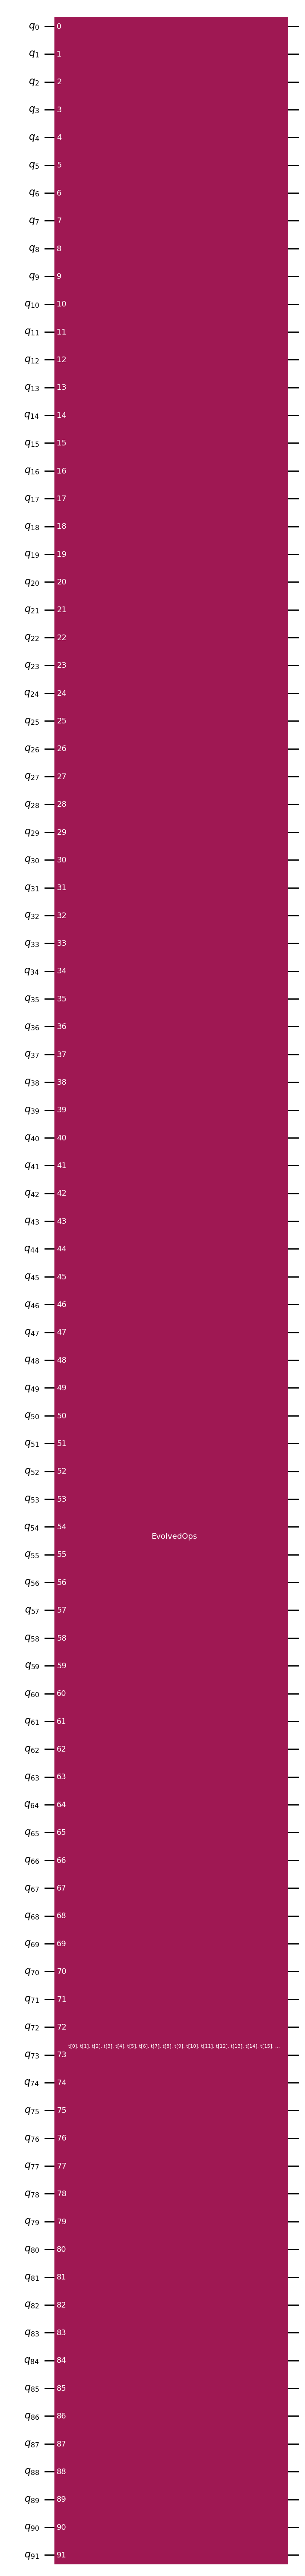

In [59]:
ansatz.draw('mpl')
#ansatz.decompose().draw('mpl')

In [81]:
from qiskit_aer.primitives import EstimatorV2 as AerEstimator

# 8) Estimator primitive (statevector-based reference implementation)
#estimator = Estimator()
estimator = AerEstimator()



In [82]:
# 9) Optimizer: L-BFGS-B (무노이즈 statevector 시뮬레이터에 적합)
optimizer = L_BFGS_B(maxiter=1000)

In [83]:
import datetime
import time

# 현재 시간 보관 (시작 시간)
start_time = datetime.datetime.now()

# 현재 시작 시간 표시
print(f"루틴 시작 시간: {start_time.strftime('%H시 %M분 %S초')}")

# 초기 파라미터 설정
initial_point = np.random.random(ansatz.num_parameters)

#수렴과정을 그래프로 그리기 위해 중간 상태 보관
cost_history = []

def store_intermediate_result(eval_count, parameters, mean, std):
  # 루틴 종료 시간
  end_time = datetime.datetime.now()
  # 시작 시간과 종료 시간의 차이 계산
  time_diff = end_time - start_time

  # 시:분:초로 표시
  total_seconds = int(time_diff.total_seconds())
  hours = total_seconds // 3600
  minutes = (total_seconds % 3600) // 60
  seconds = total_seconds % 60

  #print(f"총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")
  print(eval_count," 단계: ", mean, f"\t\t총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")
  cost_history.append(mean)
###def

# 10) VQE setup (qiskit.algorithms.VQE) 연결 — estimator를 사용하도록 지정
vqe = VQE(ansatz=ansatz,
          optimizer=optimizer,
          estimator=estimator,
          initial_point=initial_point,
          callback=store_intermediate_result
      )

루틴 시작 시간: 07시 45분 40초


In [85]:
# 11) 실행: VQE로 하밀토니언 기대값 최소화
#    qiskit VQE의 input은 보통 PauliSumOp 형태
result = vqe.compute_minimum_eigenvalue(qubit_op)

print("최적화 완료!!!")

# 루틴 종료 시간
end_time = datetime.datetime.now()
print(f"루틴 종료 시간: {end_time.strftime('%H시 %M분 %S초')}")

# 시작 시간과 종료 시간의 차이 계산
time_diff = end_time - start_time

# 시:분:초로 표시
total_seconds = int(time_diff.total_seconds())
hours = total_seconds // 3600
minutes = (total_seconds % 3600) // 60
seconds = total_seconds % 60

print(f"총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")


print("\nVQE energy (Hartree):", result.eigenvalue.real)

AlgorithmError: 'The primitive job to evaluate the energy failed!'

In [ ]:
# 12) 참조: 클래식 정확값과 비교 (가능하면 NumPyExact)
numpy_solver = NumPyMinimumEigensolver()
ref = numpy_solver.compute_minimum_eigenvalue(qubit_op)
print("Reference (exact diagonalization) energy (Hartree):", ref.eigenvalue.real)
